<a href="https://colab.research.google.com/github/horger89/Object-Detection/blob/main/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SETUP


In [ ]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For processing the image.
import matplotlib.pyplot as plt
import tempfile
from six import BytesIO


# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

Select and load the model
FasterRCNN + InceptionResNet V2: high accuracy

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

Load the model

In [ ]:
model = hub.load(module_handle)

Choose the default signature

In [ ]:
# take a look at the available signatures for this particular model
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction () -> Dict[['detection_class_names', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_boxes', TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)], ['detection_class_entities', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_scores', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)], ['detection_class_labels', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)]] at 0x7C24733C0790>}))

In [ ]:
detector = model.signatures['default']

Display Image

In [ ]:
def display_image(image):
    """
    Displays an image inside the notebook.

    """
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

Draw bounding boxes

In [ ]:
def draw_bounding_box_on_image(image,
                               y_min,
                               x_min,
                               y_max,
                               x_max,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """
  Adds a bounding box to an image.

  Args:
    image -- the image object.
    y_min, x_min, y_max, x_max -- bouding box coordinates.
    color -- color for the bounding box edges.
    font -- font for class label.
    thickness -- edge thickness of the bounding box.
    display_str_list -- class labels for each object detected.

  Returns:
    No return.
  """
  draw = ImageDraw.Draw(image)
  img_width, img_height = image.size

  # scale the bouding box coordinates to the height and width of the image
  (left, top, right, bottom) = (x_min * img_width, y_min * img_height,
                                x_max * img_width, y_max * img_height)

  # define the four edges of the detection box
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)], width=thickness, fill=color)

  # If the total height of the display string added to the top of the bounding
  # box exceeds the top of the image, stack the string below the bouding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2* margin),
                    (left + text_width, text_bottom),
                    ],fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """
  Overlay labeled boxes on an image with formatted scores and label names.

  Args:
    image -- the image as a numpy array
    boxes -- list of detection boxes
    class_names -- list of classes for each detected object
    scores -- numbers showing the model's confidence in detecting that object
    max_boxes -- maximum detection boxes to overlay on the image (default is 10)
    min_score -- minimum score required to display a bounding box

  Returns:
    image -- the image after detection boxes and classes are overlaid on the ogirinal
    image
  """
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    # only display detection boxes that have the minimum score or higher
    if scores[i] >= min_score:
      y_min, x_min, y_max, x_max = tuple(boxes[i])
      display_str = "{}: {}".format(class_names[i].decode("ascii"),
                                    int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      # draw one bounding box and overlay the class labels onto the image
      draw_bounding_box_on_image(image_pil,
                                 y_min, x_min, y_max, x_max,
                                 color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))

  return image

This function will take in the object detection model detector and the path to a sample image, then use this model to detect objects.

In [ ]:
def load_image(path):
  """
  Loads a JPEG image and converts it to a tensor.

  Args:
    path (string) -- path to a locally saved JPEG image

  Returns:
    (tensor) -- an image tensor
  """
  # read the file
  img = tf.io.read_file(path)

  # convert to a tensor
  img = tf.image.decode_jpeg(img, channels=3)

  return img

def run_detector(detector, path):
  """
  Runs inference on a local file using an object detection model.

  Args:
    detector (model) -- an object detection model loaded from TF Hub.
    path (string) -- path to an image saved locally
  """
  # load an image tensor from a local file path
  img = load_image(path)

  # add a batch dimension in front of the tensor
  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  # run inference using the model
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  # save the results in a dictionary
  result = {key: value.numpy() for key, value in result.items()}

  # print results
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time - start_time)

  # draw predicted boxes over the image
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"]
  )

  # display the image
  display_image(image_with_boxes)

Select and load an image and save locally

In [ ]:
from google.colab import files

uploaded=files.upload()

for fn in uploaded.keys():

  path='/content/' + fn

Saving IMG_0275.jpeg to IMG_0275 (2).jpeg


Display Image

<ipython-input-36-ffd7ec1e6101>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (1280, 865), Image.ANTIALIAS)


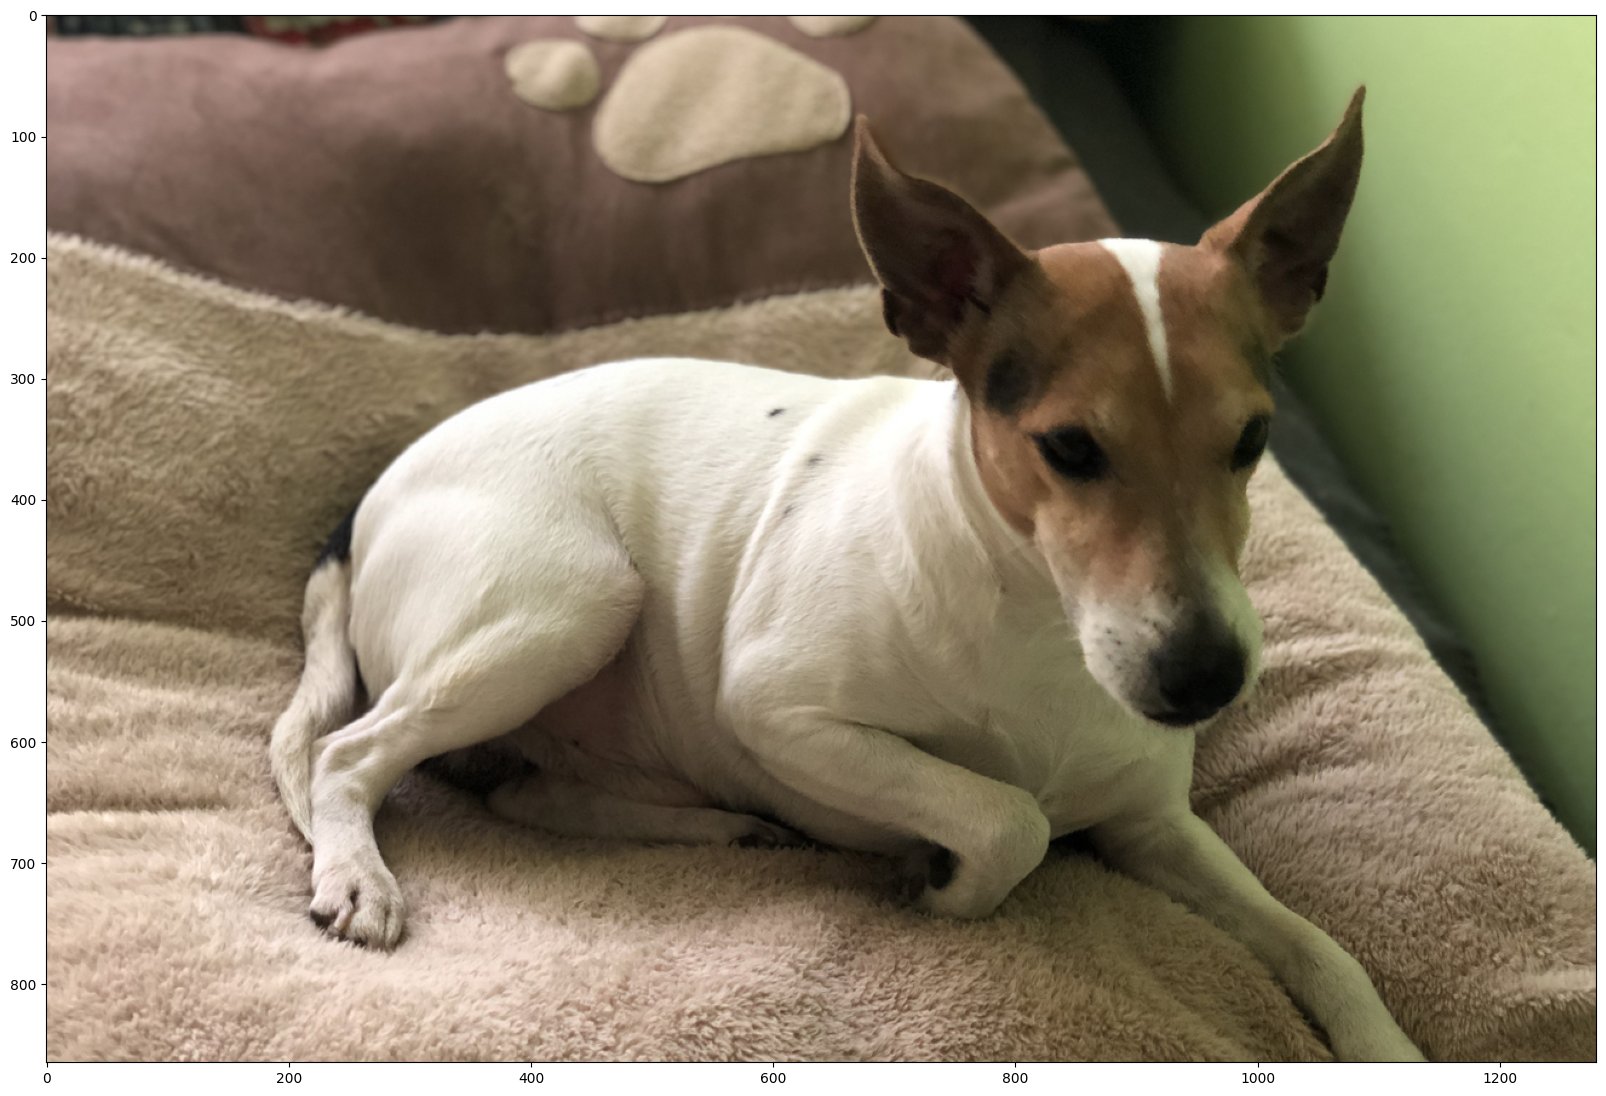

In [ ]:
# opens the image
pil_image = Image.open(path)

# resizes the image. will crop if aspect ratio is different.
pil_image = ImageOps.fit(pil_image, (1280, 865), Image.ANTIALIAS)

# converts to the RGB colorspace
pil_image_rgb = pil_image.convert("RGB")
display_image(pil_image)

Run the detector on your selected image!

Found 100 objects.
Inference time:  32.79420042037964


<ipython-input-8-460fac957164>:38: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-8-460fac957164>:49: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


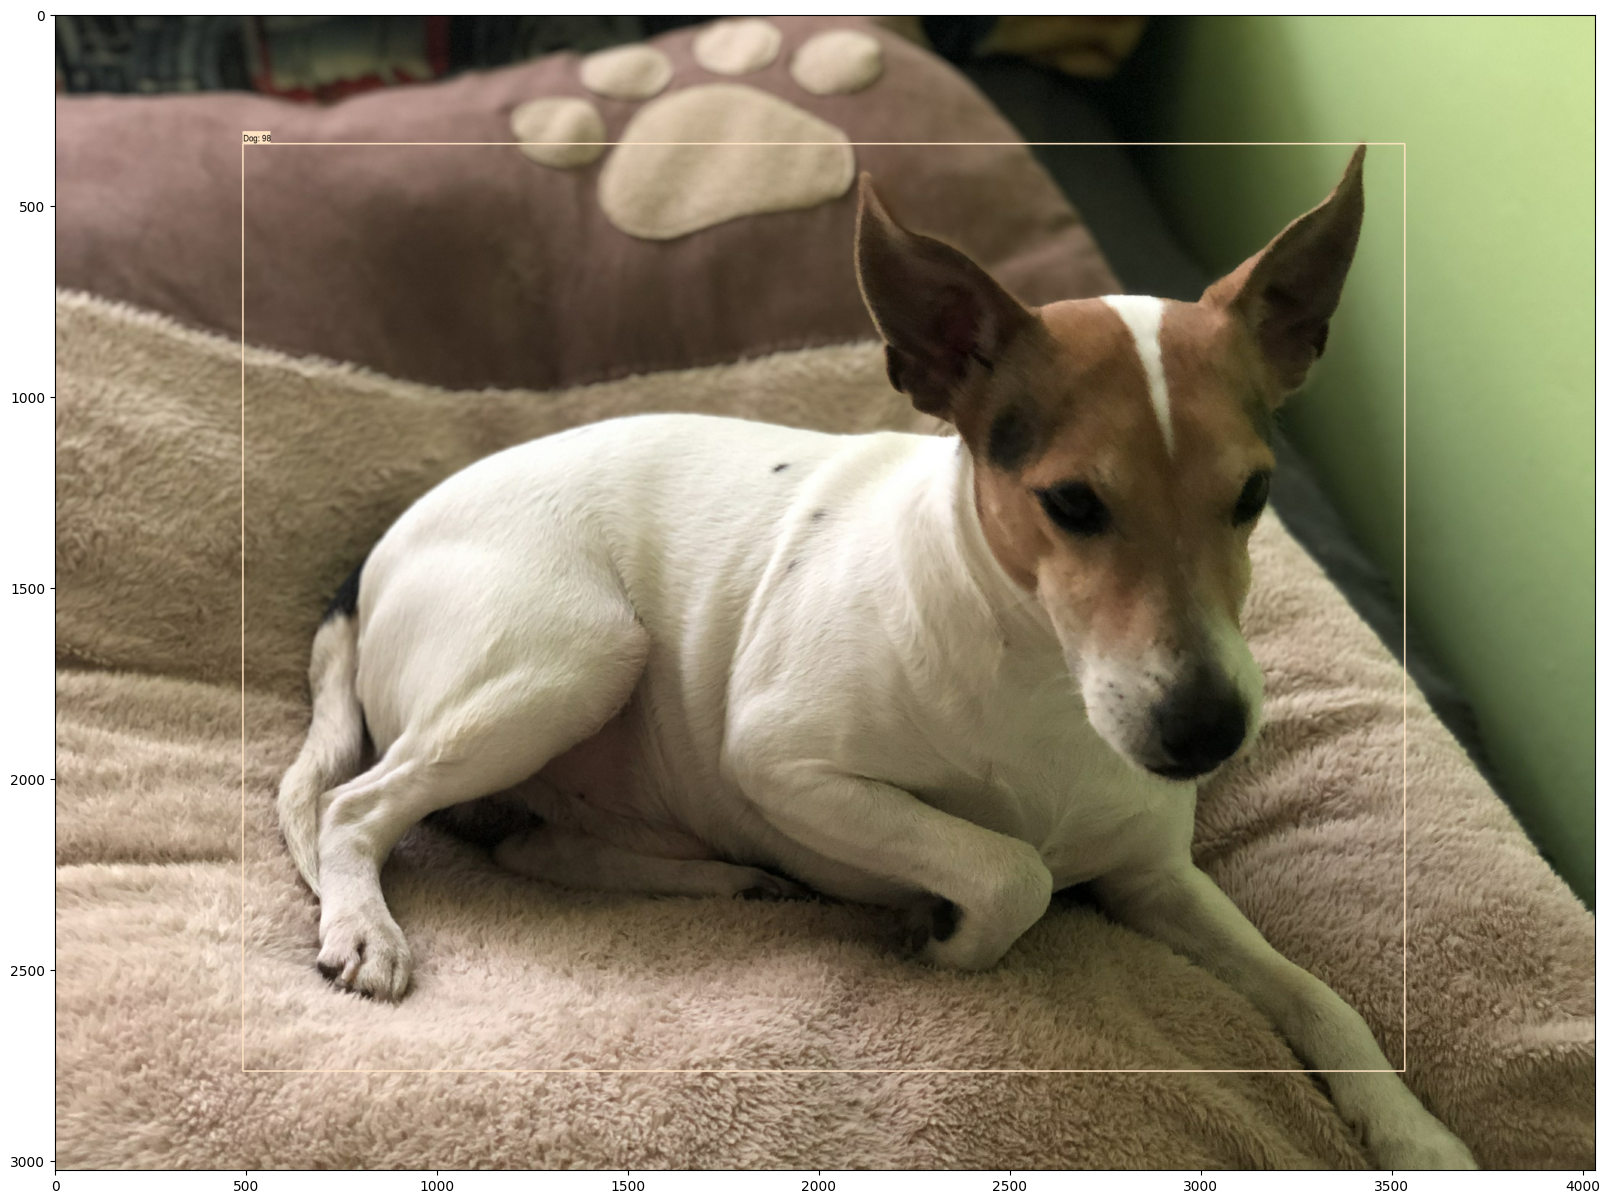

In [ ]:
run_detector(detector, path)